## **Mô hình Logistics Regression phân lớp các đơn giao trễ (Classification)**

### **Bước 1: Load bộ dữ liệu**

In [8]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('DataCoSC').getOrCreate()
data_path = 'D:/Downloads/DataCo_Cleaned/DataCo_Cleaned/Dataclean.csv'
df_DataCoSC = spark.read \
.option("header", "True") \
.option("inferSchema", "True") \
.option("sep", ",") \
.csv(data_path)
#####################################################
print("There are", df_DataCoSC.count(),
"rows", len(df_DataCoSC.columns),
"columns in the data.")
#####################################################
target_feature = 'Late_delivery_risk'
indep_features = [col for col in df_DataCoSC.columns if col not in [target_feature]]

There are 180508 rows 51 columns in the data.


### **Bước 2: Chuyển đổi dữ liệu**

In [2]:
from pyspark.sql.functions import to_date, datediff, col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Bước 3: Chuyển đổi kiểu dữ liệu và tạo biến shipping_delay
df = df_DataCoSC.withColumn("Late_delivery_risk", col("Late_delivery_risk").cast("int")) \
      .withColumn("shipping_date", to_date(col("`shipping date (DateOrders)`"), "M/d/yyyy H:mm")) \
      .withColumn("order_date", to_date(col("`order date (DateOrders)`"), "M/d/yyyy H:mm")) \
      .withColumn("shipping_delay", datediff(col("shipping_date"), col("order_date")))


# Bước 4: Các đặc trưng định lượng
indep_features = ['Days for shipping (real)', 'Days for shipment (scheduled)',
                 'Benefit per order', 'Sales per customer',
                 'Order Item Discount', 'Order Item Product Price',
                 'Order Item Profit Ratio', 'Order Item Quantity',
                 'shipping_delay']


# Các cột định tính cần xử lý
categorical_cols = ['Customer Segment', 'Shipping Mode']


# Bước 5: Tạo stages_list để dùng cho pipeline
stages_list = []


# Encode các biến phân loại
for col_name in categorical_cols:
   indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index", handleInvalid='keep')
   encoder = OneHotEncoder(inputCol=f"{col_name}_index", outputCol=f"{col_name}_encoded")
   stages_list += [indexer, encoder]


# Tổng hợp tất cả biến đặc trưng
final_features = indep_features + [f"{c}_encoded" for c in categorical_cols]
assembler = VectorAssembler(inputCols=final_features, outputCol="features")
stages_list += [assembler]


# Bước 7: Tạo pipeline
pipeline = Pipeline(stages=stages_list)


# Bước 8: Fit pipeline và transform toàn bộ dữ liệu
pipeline_model = pipeline.fit(df)
df_transformed = pipeline_model.transform(df)


# Bước 9: Chia train/test
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)


train_data.show(n=5)

+----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+----------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------+-------------+--------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+----------------+------------+---------------+-------------------+--------------------+--------------------+-------------+--------------+--------------------------+-------------+-------------+----------+--------------+----------------------+------------------------+-------------------+--------------

### **Bước 3: Sử dụng mô hình logistic regression**

In [3]:
from pyspark.ml.classification import LogisticRegression
# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol=target_feature, maxIter=10) \
.fit(train_data)
# Make predictions on the test set
lr_predictions = lr.transform(test_data)

### **Bước 4: Chỉ số ROC**

In [4]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol=target_feature)
area_under_curve = evaluator.evaluate(lr_predictions)
print(f"Area under ROC curve: {area_under_curve}")

Area under ROC curve: 0.9734736243905268


### **Bước 5: Vẽ đường cong ROC**

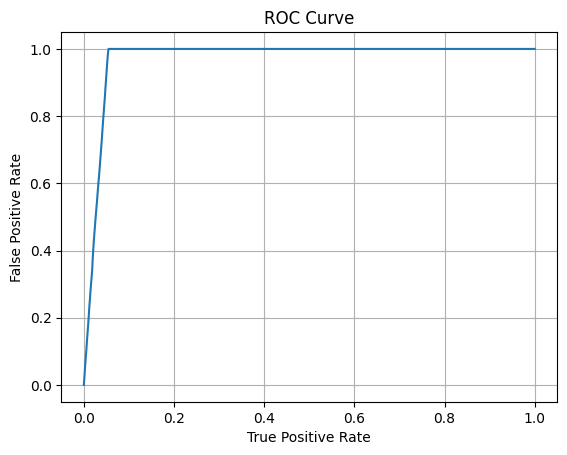

Training set areaUnderROC: 0.9730698680353114


In [5]:
from matplotlib import pyplot as plt
trainingSummary = lr.summary
lrROC = trainingSummary.roc.toPandas()
plt.plot(lrROC['FPR'], lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### **Bước 6: Vẽ biểu đồ RECALL và PRECISION**

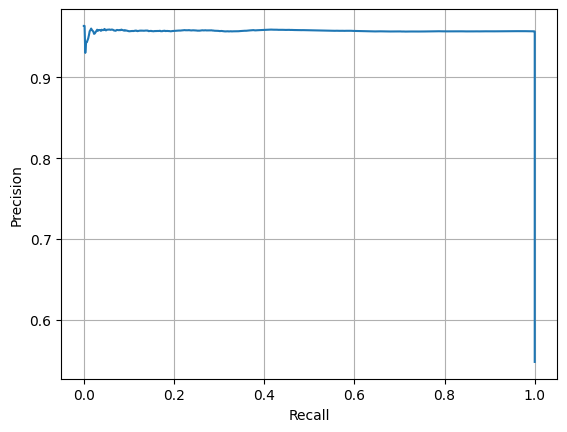

In [6]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'], pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.show()

### **Bước 7: Chỉ số đánh giá mô hình**

In [7]:
from pyspark.sql.functions import column as col
# Calculate true positives, true negatives, false positives, false negatives
tp = lr_predictions.filter((col(target_feature) == 1) & (col('prediction') == 1)).count()
tn = lr_predictions.filter((col(target_feature) == 0) & (col('prediction') == 0)).count()
fp = lr_predictions.filter((col(target_feature) == 0) & (col('prediction') == 1)).count()
fn = lr_predictions.filter((col(target_feature) == 1) & (col('prediction') == 0)).count()
# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Accuracy: {accuracy}")
# Calculate precision
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision}")
# Calculate recall
recall = tp / (tp + fn) if (tp + fn) != 0 else 0.0
print(f"Recall: {recall}")
# Calculate F1 measure
f1_measure = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
print(f"F1 measure: {f1_measure}")

Accuracy: 0.9758831237627903
Precision: 0.9579933954933955
Recall: 1.0
F1 measure: 0.9785460948932265
